<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

## CAPSTONE PROJECT - CREDIT CARD FRAUD DETECTION------------By SadviSandhya

In [2]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0,9.0)
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model, Sequential 
from keras import regularizers

import warnings
warnings.filterwarnings('ignore')

## Data


In [3]:
#To read the file and check few data
cred_df = pd.read_csv('creditcard.csv')


In [4]:
## Check data#fraud transction details#Normal transaction details

print('data is a %s' % type(cred_df))
print('data has %d rows and %d columns' % cred_df.shape)
print('Basic Statistics about data%s' % ('_'*50))
print(cred_df.describe())
print('')
print('Sample of data%s' % ('_'*50))
print(cred_df.head())

print('fraud transction details %s' % cred_df.Amount[cred_df.Class == 1].describe())

print('Normal transaction details %s' % cred_df.Amount[cred_df.Class == 0].describe())
print('Fraud and Non-fraud transaction counts %s' % ('_'*50))   
print(cred_df.Class.value_counts()) 

data is a <class 'pandas.core.frame.DataFrame'>
data has 284807 rows and 31 columns
Basic Statistics about data__________________________________________________
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.8

### 2. EDA 



In [5]:
#cred_df.dtypes

In [6]:
#cred_df.isnull().sum() # No null values

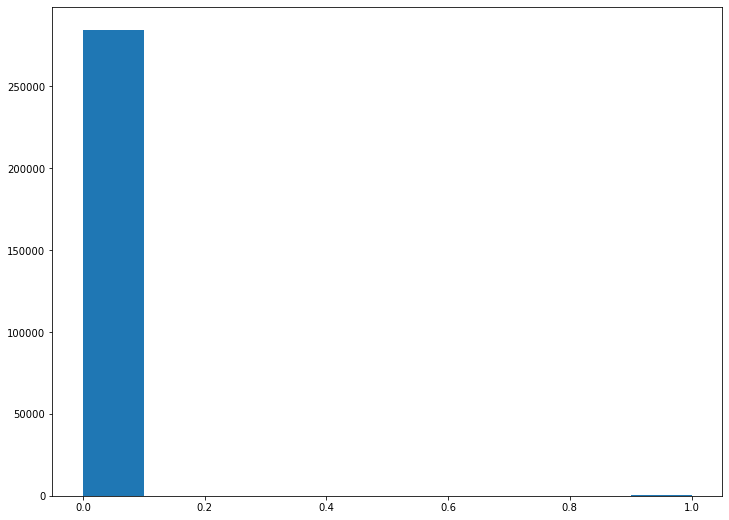

In [7]:
plt.hist(cred_df.Class)
plt.show()

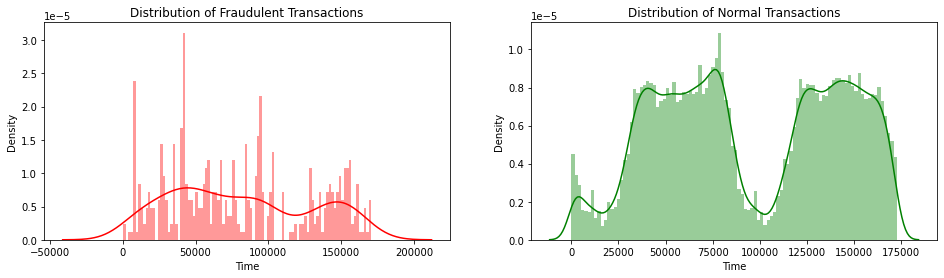

In [8]:
# transaction distribution
fig, axs = plt.subplots(ncols=2, figsize=(16,4))

sns.distplot(cred_df[(cred_df['Class'] == 1)]['Time'], bins=100, color='red', ax=axs[0])
axs[0].set_title("Distribution of Fraudulent Transactions")

sns.distplot(cred_df[(cred_df['Class'] == 0)]['Time'], bins=100, color='green', ax=axs[1])
axs[1].set_title("Distribution of Normal Transactions")

plt.show()

#fraudulent transactions (amount) against time. The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

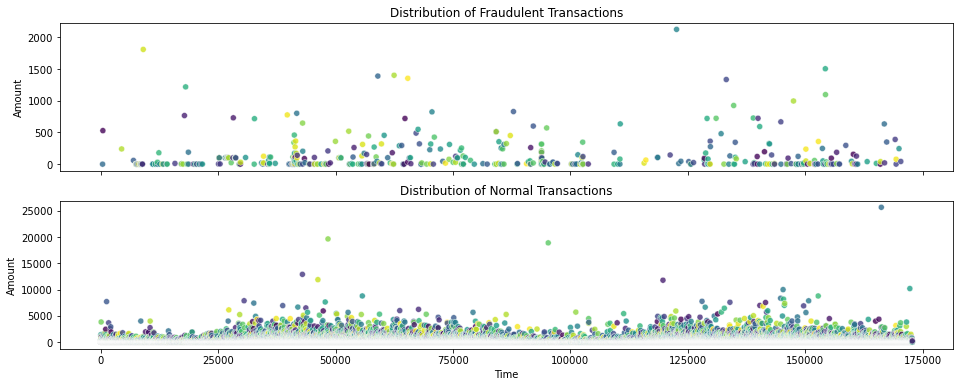

In [9]:
fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(16,6))
colors = np.random.rand(492)
colors1= np.random.rand(284315)
sns.scatterplot(x='Time',y='Amount', data=cred_df[cred_df['Class']==1],c=colors, alpha=0.8, ax=axs[0])
axs[0].set_title("Distribution of Fraudulent Transactions")

sns.scatterplot(x='Time',y='Amount', data=cred_df[cred_df['Class']==0],c=colors1, alpha=0.8, ax=axs[1])
axs[1].set_title("Distribution of Normal Transactions")

plt.show()

In [15]:
# converting seconds to time delta to extract hours and mins

timedelta = pd.to_timedelta(cred_df['Time'], unit='s')

cred_df['mins'] = (timedelta.dt.components.minutes).astype(int)
cred_df['hours'] = (timedelta.dt.components.hours).astype(int)

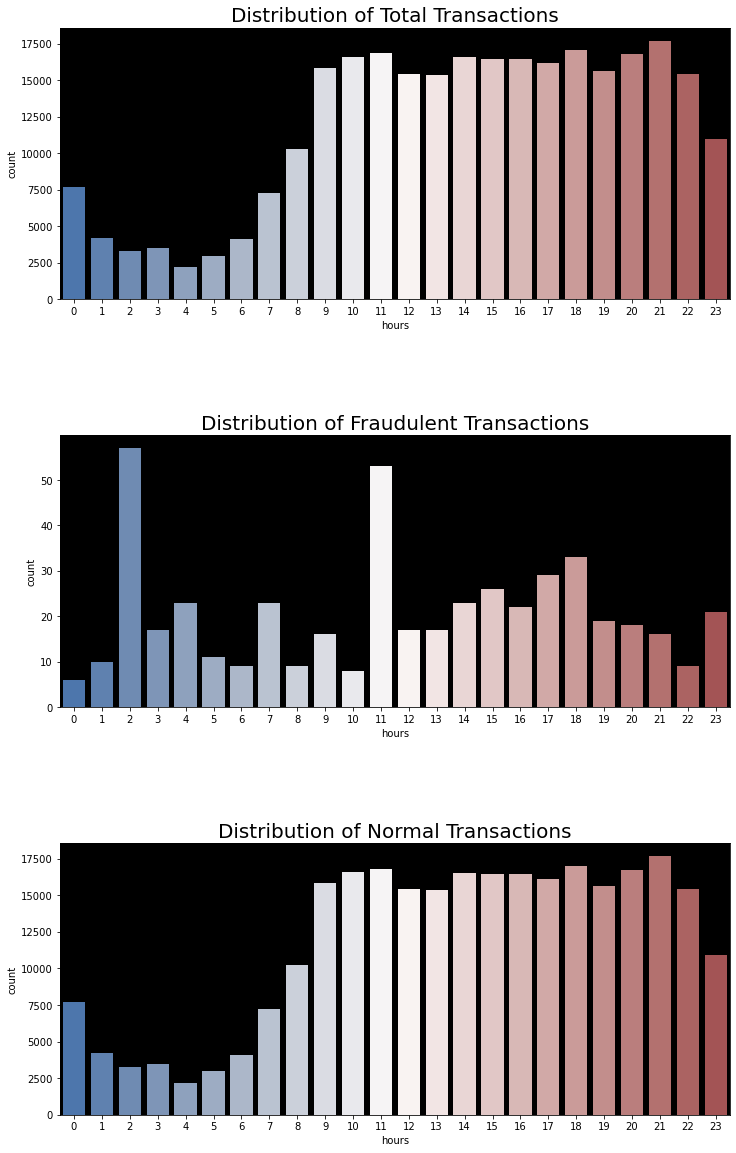

In [16]:
# Countplots for hours vs count of transactions

fig, axs = plt.subplots(3, figsize=(12,20))

fig.subplots_adjust(hspace=.5)

sns.countplot(cred_df['hours'], ax = axs[0], palette="vlag")
axs[0].set_title("Distribution of Total Transactions",fontsize=20)
axs[0].set_facecolor("black")

sns.countplot(cred_df[(cred_df['Class'] == 1)]['hours'], ax=axs[1], palette='vlag')
axs[1].set_title("Distribution of Fraudulent Transactions", fontsize=20)

axs[1].set_facecolor('black')

sns.countplot(cred_df[(cred_df['Class'] == 0)]['hours'], ax=axs[2], palette='vlag')
axs[2].set_title("Distribution of Normal Transactions", fontsize=20)
axs[2].set_facecolor("black")

plt.show()

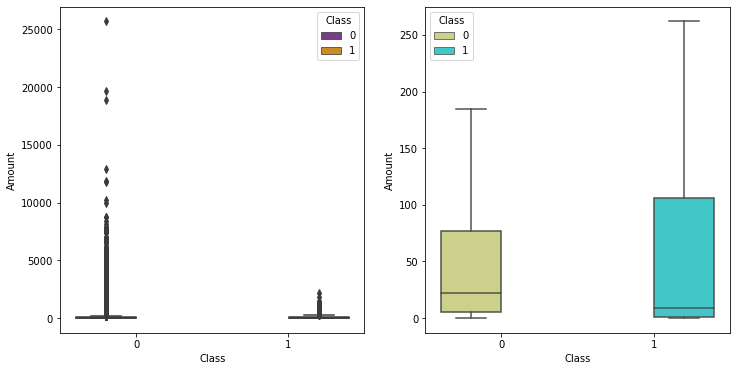

In [17]:
#Bix plot to check the outliers
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=cred_df, palette="CMRmap",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=cred_df, palette="rainbow_r",showfliers=False)
plt.show();

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

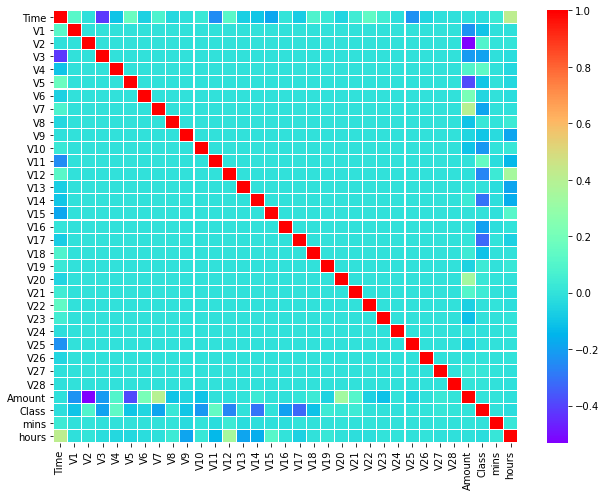

In [18]:
#correlation
cred_corr = cred_df.corr()
fig, ax = plt.subplots(figsize=(9, 7))

sns.heatmap(cred_corr, xticklabels=cred_corr.columns, yticklabels=cred_corr.columns, linewidths=.1, cmap="rainbow", ax=ax)
plt.tight_layout()

In [19]:
##V3,time (-0.4)(inverse)
## Amount v7,v20(0.4,0.5)
## Amount v1,v2,v5(-0.2,-0.4,-0.3)

<Figure size 864x648 with 0 Axes>

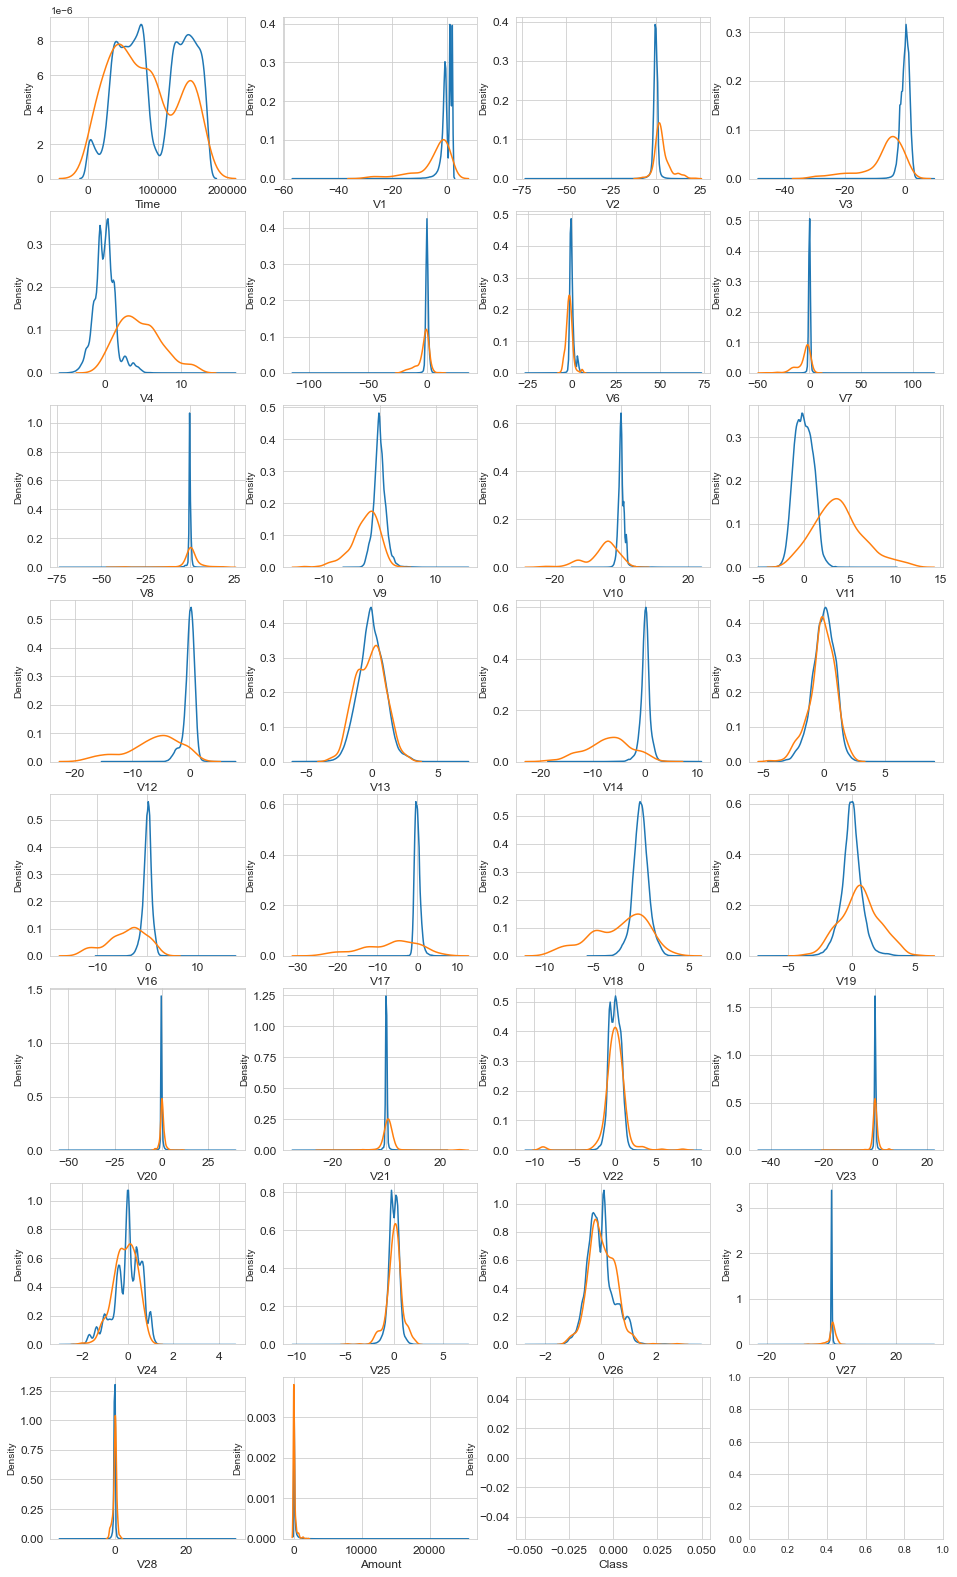

In [12]:
#Plot univariate or bivariate distributions using kernel density estimation.
#A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.
#Relative to a histogram, KDE can produce a plot that is less cluttered and more interpretable, especially when drawing multiple distributions. But it has the potential to introduce distortions if the underlying distribution is bounded or not smooth. 
#Like a histogram, the quality of the representation also depends on the selection of good smoothing parameters.
var = cred_df.columns.values

i = 0
t0 = cred_df.loc[cred_df['Class'] == 0]
t1 = cred_df.loc[cred_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature],label="Class = 0")
    sns.kdeplot(t1[feature],label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

For some of the features we can observe a good selectivity in terms of distribution for the two values of Class: V4, V11 have clearly separated distributions for Class values 0 and 1, V12, V14, V18 are partially separated, V1, V2, V3, V10 have a quite distinct profile, whilst V25, V26, V28 have similar profiles for the two values of Class.

#In general, with just few exceptions (Time and Amount), the features distribution for legitimate transactions (values of Class = 0) is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of Class = 1) have a skewed (asymmetric) distribution.

In [20]:
cred_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'mins', 'hours'],
      dtype='object')

In [21]:
print("The skewness of the Amount feature is: ", cred_df['Amount'].skew())
print("The skewness of the Time feature is: ", cred_df['Time'].skew())


The skewness of the Amount feature is:  16.977724453761024
The skewness of the Time feature is:  -0.0355676180063216


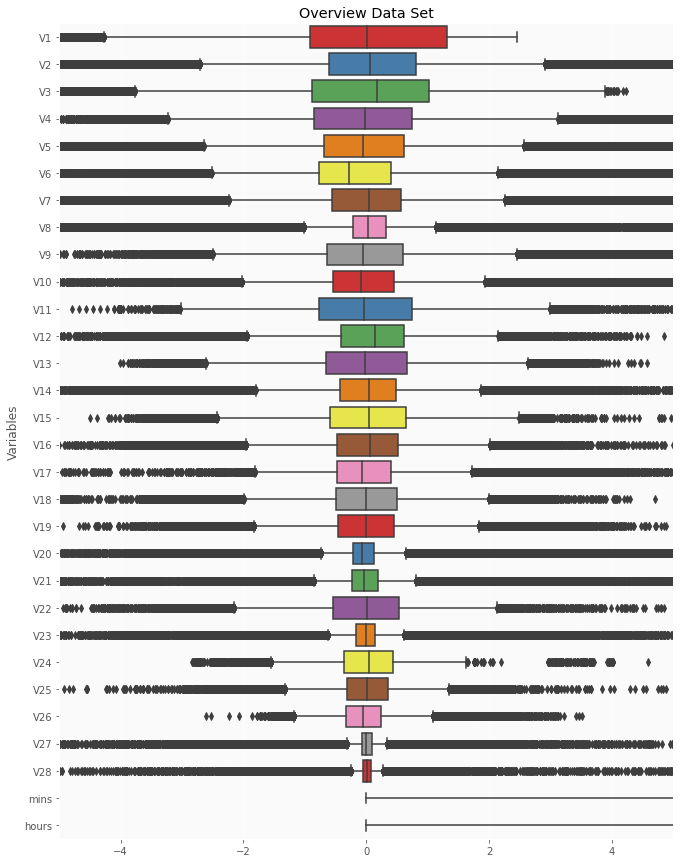

In [27]:
#box plot of v1 to v28

plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-5, 5))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = cred_df.drop(columns=['Amount', 'Class', 'Time']), 
  orient = 'h', 
  palette = 'Set1')

<AxesSubplot:xlabel='Class', ylabel='V11'>

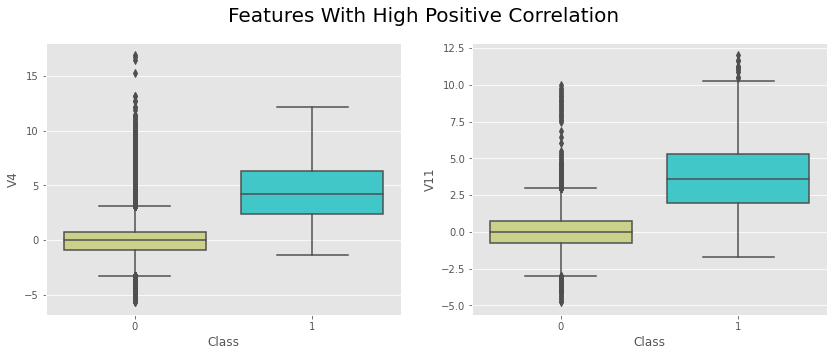

In [28]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

f.suptitle('Features With High Positive Correlation', size=20)
sns.boxplot(x="Class", y="V4", data=cred_df, palette="rainbow_r", ax=axes[0])
sns.boxplot(x="Class", y="V11", data=cred_df,palette="rainbow_r", ax=axes[1])

### Clustering with tSNE

In [29]:
#Visualize the data with t-SNE TNSE(t-distributed Stochastic Neighbor Embedding) is one of the dimensionality reduction method. This will supress some noise and speed up the computation of pairwise distance between samples.

In [30]:
card_df = pd.read_csv("creditcard.csv")
card_df.shape

(284807, 31)

In [31]:
# Change the time attribute in day
card_df['Time'] = card_df['Time'].apply(lambda t: (t/3600) % 24 )

In [32]:
# Sampling of data
normal_trans = card_df[card_df['Class'] == 0].sample(4000)
fraud_trans = card_df[card_df['Class'] == 1]

In [33]:
reduced_set = normal_trans.append(fraud_trans).reset_index(drop=True)
print(f"Cleansed dataset shape : {reduced_set.shape}")

Cleansed dataset shape : (4492, 31)


In [34]:
# Splitting the dataset into X and y features
y = reduced_set['Class']
X = reduced_set.drop('Class', axis=1)
print(f"Shape of Features : {X.shape} and Target: {y.shape}")

Shape of Features : (4492, 30) and Target: (4492,)


In [35]:
def dimensionality_plot(X, y):
    sns.set(style='whitegrid', palette='muted')
    # Initializing TSNE object with 2 principal components
    tsne = TSNE(n_components=2, random_state = 42)
    
    # Fitting the data
    X_trans = tsne.fit_transform(X)
    
    plt.figure(figsize=(12,8))
    
    plt.scatter(X_trans[np.where(y == 0), 0], X_trans[np.where(y==0), 1], alpha=0.8, label='Normal')
    plt.scatter(X_trans[np.where(y == 1), 0], X_trans[np.where(y==1), 1], alpha=0.8, label='Fraud')
    
    plt.legend(loc = 'best')
    
    plt.show()

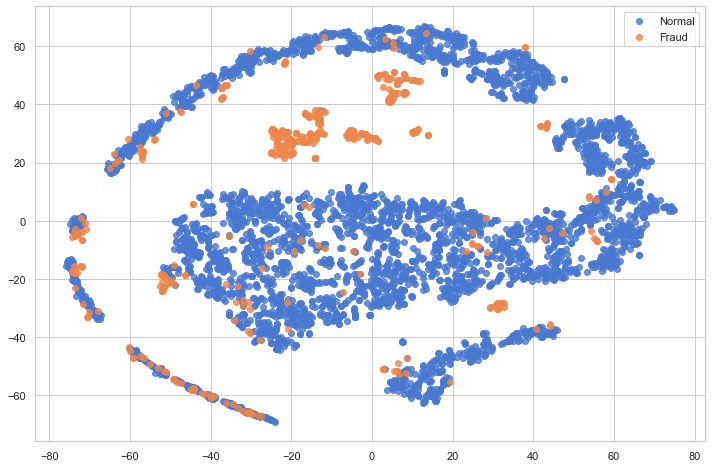

Wall time: 54 s


In [36]:
%%time
# Invoking the method dimensionality_plot
dimensionality_plot(X, y)

In [37]:
#Normalize and Scale the features
scaler = RobustScaler().fit_transform(X)

# Scaled data
X_scaled_normal = scaler[y == 0]
X_scaled_fraud = scaler[y == 1]
print(f"Shape of the input data : {X.shape[1]}")

Shape of the input data : 30


#### Building Autoencoder Model

In [38]:
# Input layer with a shape of features/columns of the dataset
input_layer = Input(shape = (X.shape[1], ))

# Construct encoder network
encoded = Dense(100, activation= 'tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(25, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(12, activation = 'tanh', activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(6, activation='relu')(encoded)

# Decoder network
decoded = Dense(12, activation='tanh')(encoded)
decoded = Dense(25, activation='tanh')(decoded)
decoded = Dense(50, activation='tanh')(decoded)
decoded = Dense(100, activation='tanh')(decoded)

output_layer = Dense(X.shape[1], activation='relu')(decoded)

# Building a model
auto_encoder = Model(input_layer, output_layer)


In [39]:
%%time
# Compile the auto encoder model
auto_encoder.compile(optimizer='adadelta', loss='mse',metrics=['accuracy'])
# #model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# Training the auto encoder model
history = auto_encoder.fit(X_scaled_normal, X_scaled_normal, batch_size=32, epochs=40, shuffle=True, validation_split=0.20)

Epoch 1/40
100/100 [==============================] - 1s 10ms/step - loss: 2.0700 - accuracy: 0.0344 - val_loss: 2.3475 - val_accuracy: 0.0338
Epoch 2/40
100/100 [==============================] - 0s 3ms/step - loss: 2.0693 - accuracy: 0.0344 - val_loss: 2.3467 - val_accuracy: 0.0362
Epoch 3/40
100/100 [==============================] - 0s 3ms/step - loss: 2.0686 - accuracy: 0.0353 - val_loss: 2.3459 - val_accuracy: 0.0375
Epoch 4/40
100/100 [==============================] - 0s 3ms/step - loss: 2.0679 - accuracy: 0.0366 - val_loss: 2.3452 - val_accuracy: 0.0375
Epoch 5/40
100/100 [==============================] - 0s 4ms/step - loss: 2.0673 - accuracy: 0.0369 - val_loss: 2.3445 - val_accuracy: 0.0388
Epoch 6/40
100/100 [==============================] - 0s 5ms/step - loss: 2.0667 - accuracy: 0.0378 - val_loss: 2.3438 - val_accuracy: 0.0400
Epoch 7/40
100/100 [==============================] - 1s 5ms/step - loss: 2.0660 - accuracy: 0.0394 - val_loss: 2.3431 - val_accuracy: 0.0437
Epoch

In [40]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [41]:
#Using Autoencode to encode data
latent_model = Sequential()
latent_model.add(auto_encoder.layers[0])
latent_model.add(auto_encoder.layers[1])
latent_model.add(auto_encoder.layers[2])
latent_model.add(auto_encoder.layers[3])
latent_model.add(auto_encoder.layers[4])

In [42]:
normal_tran_points = latent_model.predict(X_scaled_normal)
fraud_tran_points = latent_model.predict(X_scaled_fraud)
# Making as a one collection
encoded_X = np.append(normal_tran_points, fraud_tran_points, axis=0)
y_normal = np.zeros(normal_tran_points.shape[0])
y_fraud = np.ones(fraud_tran_points.shape[0])
encoded_y = np.append(y_normal, y_fraud, axis=0)

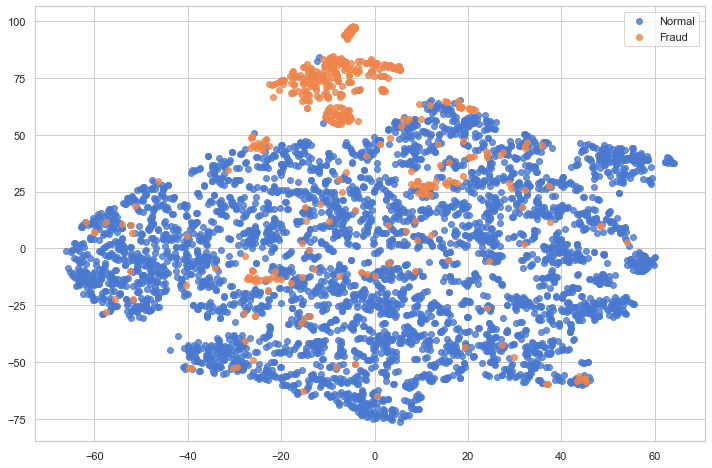

Wall time: 53.7 s


In [43]:
%%time
# Calling TSNE plot function
dimensionality_plot(encoded_X, encoded_y)

We can see that the encoded fraud data points have been moved towards one cluster, whereas there are only few fraud transaction datapoints are there among the normal transaction data points.